In [2]:
import pandas as pd # To structure and manipulated data in a DataFrame format
import numpy as np
import geopandas as gpd # To work with spatial data in a DataFrame
from geopandas import GeoDataFrame # To create a GeoDataFrame from a DataFrame
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame
import folium # To generate a Leaflet-based map of my data throughout my analysis 

In [3]:
# fname = '/media/psf/Home/Downloads/Run_to_the_hills_.gpx'
fname = '/media/psf/Home/Documents/GitHub/GPX/southseaLoop.gpx'

I think we can read gpx straight into geopandas dataframe, but this does lose the speed and elevation data (if you  use layer='tracks'.

Seems that gpxpy.parse is the best option to get gpx into df

In [4]:
gdf = gpd.read_file(fname, layer='tracks')
gdf

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Southsea loop,None,None,None,None,None,None,None,None,None,None,cycling,"MULTILINESTRING ((-0.93328 51.01343, -0.93323 ..."


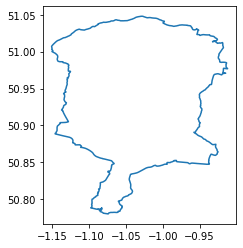

In [4]:
gdf.plot()

In [6]:
gdf.to_file(fname + ".json", driver='GeoJSON')

In [7]:
m1 = folium.Map([gdf.unary_union.centroid.y, gdf.unary_union.centroid.x])
folium.GeoJson(gdf).add_to(m1)
m1

In [8]:
centre_lat = gdf.unary_union.centroid.y
centre_long = gdf.unary_union.centroid.x
print (centre_lat,centre_long)

50.92222349092053 -1.033250206022874


perhaps we need to get the points into a separate geo dataframe

In [9]:
gdf_points = gpd.read_file(fname, layer='track_points')
gdf_points = gdf_points[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()


my way of getting the difference between the 'time' and 'ele' between consecutive points.  I don't need make_lines function or to loop through the file to get this information.

In [10]:
# time_change = pd.to_datetime(gdf_points.loc[x + 1, time], infer_datetime_format=True) - pd.to_datetime(gdf_points.loc[x, time], infer_datetime_format=True)
# time_change_seconds = time_change.seconds
gdf_points['time_change'] = pd.to_datetime(gdf_points['time']).diff()
gdf_points['ele_change'] = gdf_points['ele'].diff()
gdf_points['time_change'].fillna(pd.Timedelta(seconds=0), inplace=True)
gdf_points['ele_change'].fillna(0, inplace=True)
gdf_points.head()

,track_seg_point_id,ele,time,geometry,time_change,ele_change
0,0,78.800003,2020-06-16T11:12:51,POINT (-0.93328 51.01343),00:00:00,0.000000
1,1,78.800003,2020-06-16T11:12:52,POINT (-0.93323 51.01345),00:00:01,0.000000
2,2,78.800003,2020-06-16T11:12:54,POINT (-0.93309 51.01348),00:00:02,0.000000
3,3,79.000000,2020-06-16T11:12:57,POINT (-0.93289 51.01350),00:00:03,0.199997
4,4,78.400002,2020-06-16T11:13:01,POINT (-0.93258 51.01355),00:00:04,-0.599998


In [11]:
# convert GeodataFrame to a crs for metres rather than degrees so we can get speed calcs
gdf_points.to_crs(epsg=3310,inplace=True)
l=gdf_points.distance(gdf_points.shift())
# l is metres travelled
# l / time_change is metres/sec travelled
gdf_points['kmh'] = (l / gdf_points['time_change'].dt.seconds / 1000 ) * 3600 
# convert back to original crs
gdf_points = gdf_points.to_crs(epsg = 4326)
gdf_points.head()

,track_seg_point_id,ele,time,geometry,time_change,ele_change,kmh
0,0,78.800003,2020-06-16T11:12:51,POINT (-0.93328 51.01343),00:00:00,0.000000,NaN
1,1,78.800003,2020-06-16T11:12:52,POINT (-0.93323 51.01345),00:00:01,0.000000,16.814238
2,2,78.800003,2020-06-16T11:12:54,POINT (-0.93309 51.01348),00:00:02,0.000000,18.162513
3,3,79.000000,2020-06-16T11:12:57,POINT (-0.93289 51.01350),00:00:03,0.199997,18.254748
4,4,78.400002,2020-06-16T11:13:01,POINT (-0.93258 51.01355),00:00:04,-0.599998,20.620444


use mean, std dev, and abs to find any speed outliers and drop those rows

In [14]:
gdf_p2 = gdf_points[gdf_points['kmh'].sub(gdf_points['kmh'].mean()).div(gdf_points['kmh'].std()).abs().lt(5)]
gdf_p2.head()


,track_seg_point_id,ele,time,geometry,time_change,ele_change,kmh
1,1,78.800003,2020-06-16T11:12:52,POINT (-0.93323 51.01345),00:00:01,0.000000,16.814238
2,2,78.800003,2020-06-16T11:12:54,POINT (-0.93309 51.01348),00:00:02,0.000000,18.162513
3,3,79.000000,2020-06-16T11:12:57,POINT (-0.93289 51.01350),00:00:03,0.199997,18.254748
4,4,78.400002,2020-06-16T11:13:01,POINT (-0.93258 51.01355),00:00:04,-0.599998,20.620444
5,5,78.400002,2020-06-16T11:13:04,POINT (-0.93232 51.01359),00:00:03,0.000000,23.559698


drop time_change as Object of type 'Timedelta' is not JSON serializable

In [16]:
gdf_p2 = gdf_p2.drop('time_change', axis=1)

write out gdf_p2 points info to geojson file

In [17]:
gdf_p2.to_file(fname + "_points.geojson", driver='GeoJSON')

can print the shape object easily but can't get it onto a folium interact map.

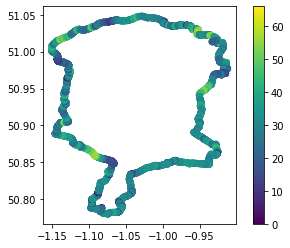

In [21]:
import matplotlib.pyplot as plt
import branca 

f = branca.element.Figure()

fig, ax = plt.subplots(1, 1)

gdf_p2.plot(column='kmh', ax=ax, legend=True)



put kmh into bins to limit the number of colors applied to the line.  By not specifying the start/end of the bins this will always color in relation to the data.  For elevation later I want to only color base on whether it's a hard climb or not

In [22]:
bins = pd.cut(gdf_p2['kmh'],bins=3, labels=[1,2,3])
bins
# x = np.linspace(0, 2*np.pi, len(gdf_p2))
# print(x)
# lats = 20 * np.cos(x)
# lons = 20 * np.sin(x)
# colors = bins
colors = gdf_p2['kmh']
colors

1       16.814238
2       18.162513
3       18.254748
4       20.620444
5       23.559698
          ...    
4351    23.447690
4352    23.793180
4353    22.621556
4354    20.324151
4355    19.205742
Name: kmh, Length: 4350, dtype: float64

if we can bin categorise speed we can categorise elevation.  I think i need to divide the elevation difference by 

In [31]:
ele_bins = pd.cut(gdf_p2['ele'],bins=5, )
ele_bins
# x = np.linspace(0, 2*np.pi, len(gdf_p2))
# print(x)
# lats = 20 * np.cos(x)
# lons = 20 * np.sin(x)
# colors = bins
# ele_colors = gdf_p2['ele_bins']
# ele_colors

1       (40.44, 84.28]
2       (40.44, 84.28]
3       (40.44, 84.28]
4       (40.44, 84.28]
5       (40.44, 84.28]
             ...      
4351    (40.44, 84.28]
4352    (40.44, 84.28]
4353    (40.44, 84.28]
4354    (40.44, 84.28]
4355    (40.44, 84.28]
Name: ele, Length: 4350, dtype: category
Categories (5, interval[float64]): [(-3.619, 40.44] < (40.44, 84.28] < (84.28, 128.12] < (128.12, 171.96] < (171.96, 215.8]]

In [24]:
from folium import features

m = folium.Map([gdf_p2.unary_union.centroid.y, gdf_p2.unary_union.centroid.x])


color_line = features.ColorLine(
    positions=list(zip(gdf_p2.geometry.y, gdf_p2.geometry.x)),
    colors=colors,
    colormap=['b', 'gray', 'r'],
    weight=5)

color_line.add_to(m)


m

drop time_change is it is an Object of type 'Timedelta' is not JSON serializable

To check my work I plotted gdf_line using folium. I was especially interested to see if the speed for each segment seemed in line with my own experience, so I symbolized by the mph column using folium's color mapping functionality.

In [13]:
# for i in range(1, len(gdf_points['kmh']>85)):
#     gdf_points.loc[i, 'kmh'] = gdf_points.loc[i-1, 'kmh']

In [22]:
gdf_points.loc[4195:4205]
# 4202 	-0.951163 	51.023068 	70.199997 	2020-06-16 14:37:24+00:00 	24.525683

,track_seg_point_id,ele,time,geometry,ele_change,kmh
4195,4195,78.199997,2020-06-16T14:37:10,POINT (-0.95329 51.02446),-1.600006,57.648878
4196,4196,76.800003,2020-06-16T14:37:11,POINT (-0.95335 51.02432),-1.399994,57.612588
4197,4197,75.800003,2020-06-16T14:37:12,POINT (-0.95341 51.02418),-1.000000,58.085247
4198,4198,75.000000,2020-06-16T14:37:13,POINT (-0.95347 51.02403),-0.800003,59.487023
4199,4199,74.599998,2020-06-16T14:37:14,POINT (-0.95353 51.02387),-0.400002,60.699860
4200,4200,71.800003,2020-06-16T14:37:19,POINT (-0.95370 51.02324),-2.799995,49.730250
4201,4201,70.800003,2020-06-16T14:37:22,POINT (-0.95218 51.02309),-1.000000,133.552198
4202,4202,70.199997,2020-06-16T14:37:24,POINT (-0.95116 51.02307),-0.600006,133.166000
4203,4203,69.400002,2020-06-16T14:37:27,POINT (-0.95061 51.02298),-0.799995,49.659081
4204,4204,68.199997,2020-06-16T14:37:29,POINT (-0.95039 51.02291),-1.200005,31.973948


In [47]:
import branca.colormap as cm
import math

f2 = folium.Figure(height = 400)
m2 = folium.Map([centre_lat, centre_long], zoom_start = 15)

max_kmh = math.ceil(gdf_points['kmh'].max())
linear = cm.linear.YlOrRd_04.scale(0,max_kmh)
gps_lyr = folium.GeoJson(gdf_points)
#                          style_function = lambda feature: {
#                              'color': linear(feature['properties']['kmh']),
#                              'weight': 5})       

gps_lyr.add_child
    
m2.add_child(linear)
m2.add_child(gps_lyr)
m2.add_to(f2)